In [378]:
import mdtraj as md 
from ase import Atoms
from nglview import show_ase
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import  GCNConv
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [379]:
# load alanine dipeptide trajectory 
molecule = md.load_pdb("../simulation/single.pdb")

In [380]:
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms] 
water = Atoms(positions= molecule.xyz[0], numbers=atomic_nums)
show_ase(water)

NGLWidget()

In [381]:
# Relative position of atoms on one molecule
poitions = molecule.xyz[0]
com = poitions.mean(axis=0)

relative_pos = poitions-com

# atomic Number
atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T

# Vander wall Radii
vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T

# Atomic Mass 
mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T


print("Relative positions:\n",relative_pos)
print("\natomic_numbers:\n",atomic_nums)
print("\nVander wall Radii:\n", vdwr)
print("\nAtomic Mass:\n",mass)

Relative positions:
 [[-0.01795 -0.03465 -0.008  ]
 [ 0.07775 -0.03465 -0.008  ]
 [-0.04185  0.05795 -0.008  ]
 [-0.01795  0.01135  0.024  ]]

atomic_numbers:
 [[8]
 [1]
 [1]
 [0]]

Vander wall Radii:
 [[0.152]
 [0.12 ]
 [0.12 ]
 [0.   ]]

Atomic Mass:
 [[15.99943 ]
 [ 1.007947]
 [ 1.007947]
 [ 0.      ]]


In [382]:
node_features = np.concatenate((relative_pos,atomic_nums,vdwr,mass),axis=1)
print("Node Features:\n",node_features)

Node Features:
 [[-1.79500002e-02 -3.46500017e-02 -8.00000038e-03  8.00000000e+00
   1.52000000e-01  1.59994300e+01]
 [ 7.77500048e-02 -3.46500017e-02 -8.00000038e-03  1.00000000e+00
   1.20000000e-01  1.00794700e+00]
 [-4.18500006e-02  5.79500012e-02 -8.00000038e-03  1.00000000e+00
   1.20000000e-01  1.00794700e+00]
 [-1.79500002e-02  1.13499984e-02  2.40000002e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [383]:
normalized_node_features = (node_features - node_features.min(axis=0))/(node_features.max(axis=0)-node_features.min(axis=0))
print("Normalized Node Features:\n",normalized_node_features)

Normalized Node Features:
 [[0.19983277 0.         0.         1.         1.         1.        ]
 [1.         0.         0.         0.125      0.78947368 0.06299893]
 [0.         1.         0.         0.125      0.78947368 0.06299893]
 [0.19983277 0.49676024 1.         0.         0.         0.        ]]


In [384]:
from_list = []
to_list = []
for edge in molecule.topology.bonds:
  from_list.append(edge.atom1.index)
  to_list.append(edge.atom2.index)
  from_list.append(edge.atom2.index)
  to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [385]:
graph = data.Data(x=torch.from_numpy(normalized_node_features),edge_index=torch.from_numpy(edge_list))

In [386]:
print(graph)

Data(x=[4, 6], edge_index=[2, 4])


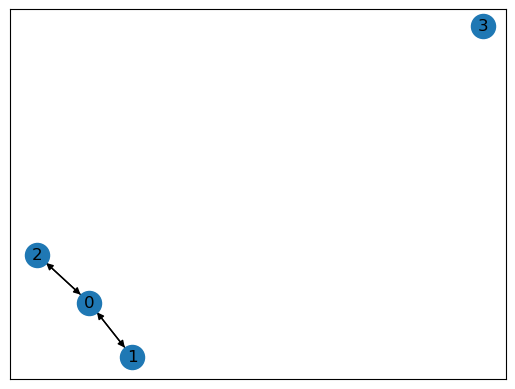

In [387]:
vis = to_networkx(graph)
nx.draw_networkx(vis)

In [388]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [389]:
graphs = [graph for _ in range(50)]

In [390]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [391]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2*out_channels, 1 * out_channels)
        self.conv_mu = GCNConv(1 * out_channels, out_channels)
        self.conv_logstd = GCNConv(1 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.silu(x)
        x = self.conv2(x, edge_index)
        x = F.silu(x)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index), edge_index


In [392]:
class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 1 * out_channels)
    def forward(self, x, edge_index, sigmoid=True):
        x = self.conv1(x, edge_index)
        x = F.silu(x)
        x = self.conv2(x, edge_index)
        x = F.silu(x)
        return x, edge_index

In [393]:
in_channels = graph.num_features
out_channels = 3
lr = 1e-4
n_epochs = 500
batch_size=2

model = VGAE(VariationalGCNEncoder(in_channels, out_channels),
             VariationalGCNDecoder(out_channels, in_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [394]:
train_loader = DataLoader(graphs, batch_size=batch_size)

In [395]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss
        loss = loss + (1 / data.num_nodes) * model.kl_loss()

        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss())

        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader.dataset), feature_loss_all / len(train_loader.dataset), edge_loss_all / len(train_loader.dataset), kl_loss_all / len(train_loader.dataset)

In [396]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []

for epoch in range(1, n_epochs + 1):
    total_loss, feature_loss, edge_loss, kl_loss = train()
    print(f'Epoch: {epoch:03d}, Total Loss: {total_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}, KL Loss: {kl_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)



Epoch: 001, Total Loss: 0.2051, Feature Loss: 0.1679, Edge Loss: 0.0000, KL Loss: 0.2970
Epoch: 002, Total Loss: 0.1964, Feature Loss: 0.1630, Edge Loss: 0.0000, KL Loss: 0.2673
Epoch: 003, Total Loss: 0.1948, Feature Loss: 0.1647, Edge Loss: 0.0000, KL Loss: 0.2407
Epoch: 004, Total Loss: 0.1869, Feature Loss: 0.1597, Edge Loss: 0.0000, KL Loss: 0.2171
Epoch: 005, Total Loss: 0.1823, Feature Loss: 0.1578, Edge Loss: 0.0000, KL Loss: 0.1962
Epoch: 006, Total Loss: 0.1819, Feature Loss: 0.1597, Edge Loss: 0.0000, KL Loss: 0.1776
Epoch: 007, Total Loss: 0.1776, Feature Loss: 0.1575, Edge Loss: 0.0000, KL Loss: 0.1610
Epoch: 008, Total Loss: 0.1754, Feature Loss: 0.1571, Edge Loss: 0.0000, KL Loss: 0.1461
Epoch: 009, Total Loss: 0.1734, Feature Loss: 0.1568, Edge Loss: 0.0000, KL Loss: 0.1327
Epoch: 010, Total Loss: 0.1668, Feature Loss: 0.1517, Edge Loss: 0.0000, KL Loss: 0.1206
Epoch: 011, Total Loss: 0.1677, Feature Loss: 0.1539, Edge Loss: 0.0000, KL Loss: 0.1098
Epoch: 012, Total Los

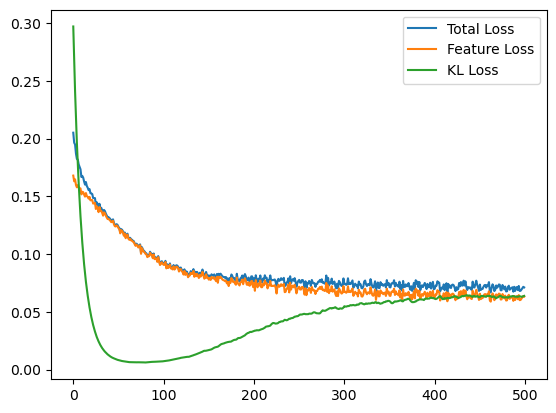

In [401]:
plt.plot(total_losses)
plt.plot(feature_losses)
# plt.plot(edge_losses)
plt.plot(kl_losses)
plt.legend(['Total Loss', 'Feature Loss', 'KL Loss'])
plt.show()

In [398]:
model.double()
z,encoded_edge_index = model.encode(graph.x,graph.edge_index)
decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)


In [399]:
print(graph.x)
print(decoded_x)


tensor([[0.1998, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.0000, 0.0000, 0.1250, 0.7895, 0.0630],
        [0.0000, 1.0000, 0.0000, 0.1250, 0.7895, 0.0630],
        [0.1998, 0.4968, 1.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)
tensor([[0.3581, 0.3579, 0.1355, 0.4998, 0.8649, 0.4386],
        [0.3487, 0.3694, 0.1462, 0.3342, 0.6930, 0.2928],
        [0.3775, 0.3259, 0.1135, 0.3689, 0.7054, 0.3237],
        [0.3263, 0.3625, 0.2944, 0.3257, 0.5676, 0.2754]], dtype=torch.float64,
       grad_fn=<SiluBackward0>)


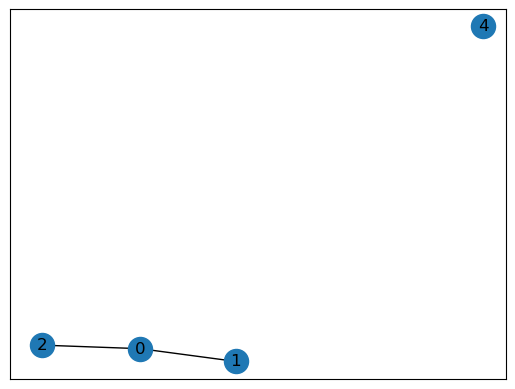

In [400]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
G.add_node(4)
nx.draw_networkx(G)
plt.show()
